In [5]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 14

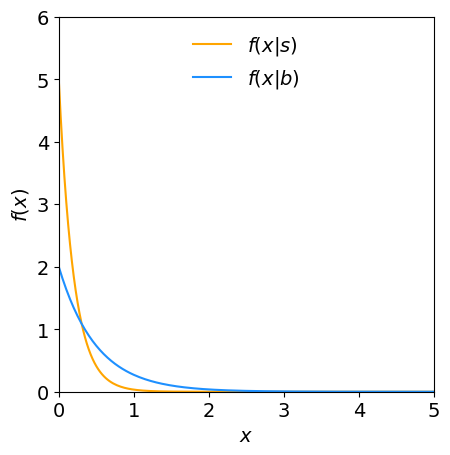

In [6]:
#  Plot the pdfs
def f_s(x):
    return 5*np.exp(-5*x)
def f_b(x):
    return 2*np.exp(-2*x)
x = np.linspace(0., 5., 201)
fs = f_s(x)
fb = f_b(x)
fig = plt.figure(figsize=(5,5))
plt.plot(x, fs, color='orange', label=r'$f(x|s)$')
plt.plot(x, fb, color='dodgerblue', label=r'$f(x|b)$')
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x)$')
plt.xlim(0., 5.)
plt.ylim(0., 6)
plt.legend(loc='upper center', frameon=False)
plt.subplots_adjust(left=0.15, right=0.9, top=0.9, bottom=0.15)
plt.show()

In [41]:
from scipy.stats import rv_continuous
class my_dist(rv_continuous):
    "f(x)=f_b(x) distribution"
    def _pdf(self, x):
        return 2*np.exp(-2*x)                # creating the pdf for background
my_Dist_back = my_dist(name='background',a=0,b=1)


In [42]:
class my_dist2(rv_continuous):
    "f(x)=f_b(x) distribution"
    def _pdf(self, x):
        return 5*np.exp(-5*x)            # creating the pdf for signal
my_Dist_sig = my_dist2(name='signal',a=0,b=1)

In [43]:
x_cut=my_Dist_back.ppf(0.05)
x_cut

np.float64(0.02564664719377544)

In [44]:
cdf=my_Dist_sig.cdf(x_cut)
cdf

np.float64(0.12035181038099177)

In [45]:
X_cut = 0.1
b_tot = 100
s_tot = 10

CDF_b = my_Dist_back.cdf(X_cut)
CDF_s = my_Dist_sig.cdf(X_cut)

s = s_tot * CDF_s
b = b_tot * CDF_b

In [46]:
s

np.float64(3.934693402873666)

In [47]:
b

np.float64(18.12692469220181)

In [48]:
pi_s = s_tot/(s_tot+b_tot)
pi_b = b_tot/(s_tot+b_tot)

In [49]:
pi_s

0.09090909090909091

In [50]:
pi_b

0.9090909090909091

In [51]:
P_s = (CDF_s * pi_s)/(CDF_s * pi_s + CDF_b * pi_b)

In [52]:
P_s


np.float64(0.17835017295272443)

In [53]:
import math
def p_value(b, n_obs):
    term_list=[]
    for n in range(n_obs):
        term = np.exp(-b) * b**n / math.factorial(n)
        term_list.append(term)
    return (1-(np.sum(term_list)))

In [54]:
p_val=p_value(0.5,3)

In [55]:
p_val

np.float64(0.014387677966970713)

In [56]:
from statistics import NormalDist

sig = NormalDist(mu=0, sigma=1).inv_cdf(1-p_val)
sig

2.186550477435837

In [57]:
# Defining the function for expected(median) significance with x_c as parameter
def ex_sig_gen(x_c):
    b_tot = 100
    s_tot = 10

    CDF_b = my_Dist_back.cdf(x_c)
    CDF_s = my_Dist_sig.cdf(x_c)

    s = s_tot * CDF_s
    b = b_tot * CDF_b

    term1 = (s+b)
    term2 = np.log(1+(s/b))
    return np.sqrt(2*((term1*term2)-s))

In [58]:
from scipy.optimize import minimize_scalar
result = minimize_scalar(
    lambda x: -ex_sig_gen(x),  # Negative for maximization
    bounds=(0,1),  # Search range
    method='bounded'
)
xc_max = result["x"]
print(xc_max)

0.39207090521842064


In [26]:
# xc = np.linspace(0,1,100)
# plt.plot(xc, ex_sig_gen(xc))
# plt.plot([xc_max,xc_max],[1,ex_sig_gen(xc_max)])
# plt.xlabel(r'$x_c$')
# plt.ylabel("Expected(median) significance")

In [10]:
import numpy as np
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 14
import pickle

In [7]:
s_tot = 10.
b_tot = 100.
ps = s_tot/(s_tot+b_tot)
def f_s(x):
    return 5*np.exp(-5*x)
def f_b(x):
    return 2*np.exp(-2*x)
def q(x):
    return -2.*np.log(1. + (s_tot/b_tot)*f_s(x)/f_b(x))

In [8]:
# Generate data under b and s+b hypotheses
qb = []
qsb = []
numExp = 100000
np.random.seed(seed=1234567)        # fix random seed
for i in range(numExp):
    n = np.random.poisson(b_tot)       # first b only
    r = np.random.uniform(0., 1., n)
    xb = 0.5*np.log(1/(1-r))
    qb.append(np.sum(q(xb)))
    n = np.random.poisson(s_tot+b_tot) # then s+b
    r1 = np.random.uniform(0., 1., n)
    r2 = np.random.uniform(0., 1., n)
    xsb = [(1/5)*np.log(1/(1-r1[j])) if r2[j]<ps else 0.5*np.log(1/(1-r1[j])) for j in range(n)]
    xsb = np.array(xsb)
    qsb.append(np.sum(q(xsb)))
    if len(qsb)%(numExp/100) == 0:
            print(".", end="", flush=True)
print("\n")
qb = np.array(qb)
qsb = np.array(qsb)

....................................................................................................



In [11]:
with open("q_bkg_n.pickle" , "wb") as outpickle:
    pickle.dump(qb, outpickle)

with open("q_sig_bkg_n.pickle" , "wb") as outpickle:
    pickle.dump(qsb, outpickle)


In [12]:
qb_n = np.array(np.load('q_bkg_n.pickle',allow_pickle=True)).flatten()
qsb_n = np.array(np.load('q_sig_bkg_n.pickle',allow_pickle=True)).flatten()

In [15]:
# Make and analyse histograms of q for b and s+b hypotheses
nBins = 400
qMin = -40.
qMax = 0.
qbHist, bin_edges = np.histogram(qb, bins=nBins, range=(qMin,qMax), density=True)
qsbHist, bin_edges = np.histogram(qsb, bins=nBins, range=(qMin,qMax), density=True)
med_q_sb = np.median(qsb)
print("median[q|s+b]   = {:.3f}".format(med_q_sb))

median[q|s+b]   = -21.420


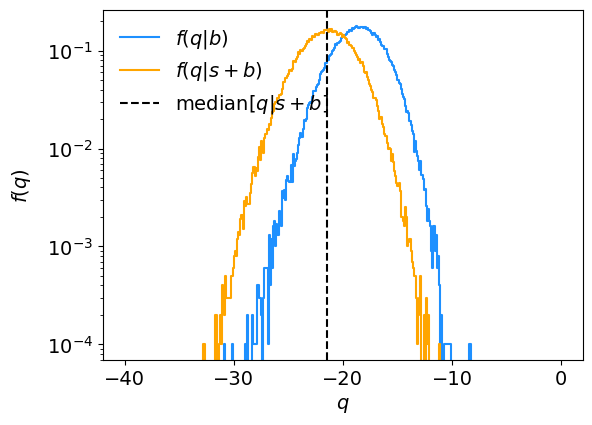

In [16]:
# Plot histograms of q
binLo, binHi = bin_edges[:-1], bin_edges[1:]
xPlot = np.array([binLo, binHi]).T.flatten()
ybPlot = np.array([qbHist, qbHist]).T.flatten()
ysbPlot = np.array([qsbHist, qsbHist]).T.flatten()
# xPlot = np.array(binLo)
# ybPlot = np.array(qbHist)
# ysbPlot = np.array(qsbHist)
fig, ax = plt.subplots(1,1)
plt.yscale("log")
plt.gcf().subplots_adjust(bottom=0.15)
plt.gcf().subplots_adjust(left=0.15)
plt.xlabel(r'$q$', labelpad=5)
plt.ylabel(r'$f(q)$', labelpad=10)
plt.plot(xPlot, ybPlot, label=r'$f(q|b)$', color='dodgerblue')
plt.plot(xPlot, ysbPlot, label=r'$f(q|s+b)$', color='orange')
ax.axvline(med_q_sb, color="black", linestyle="dashed", label = r'median$[q|s+b]$')
ax.legend(loc='upper left', frameon=False)
plt.show()